## Check Paths

In [10]:
# Check paths for meta, train, test, saving, img_path

## Installing Libraries

In [11]:
!pip install -U efficientnet
import albumentations as albu

### Importing Libraries

In [12]:
import pickle
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from pylab import rcParams

import tensorflow as tf
from keras.utils import to_categorical
import cv2
#from tensorflow.keras.preprocessing.image import ImageDataGenerator
import keras
import efficientnet.keras as efn
from tensorflow.keras.models import Sequential, load_model
from tensorflow.keras.layers import Conv2D, MaxPool2D, Dropout, Flatten, Dense, GlobalAveragePooling2D 
from tensorflow.keras.optimizers import Adam, SGD
from tensorflow.keras.callbacks import Callback, EarlyStopping, ReduceLROnPlateau
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report
from skimage.transform import resize
import albumentations as albu
import seaborn as sns


## Loading the CIFAR-100 Dataset

In [13]:
#function to open the files in the Python version of the dataset
def unpickle(file):
    with open(file, 'rb') as f:
        dict = pickle.load(f, encoding='latin1')
    return dict

## Path

In [14]:
#Local Path
# path = ''
# path

## Metadata
#### Meta file has a dictionary of fine labels and coarse labels.

In [15]:
#Kaggle Path
metadata_path = '../input/cifar100/meta'
#Local Path
#metadata_path = path + 'Data\\' + 'meta'
metadata = unpickle(metadata_path)

In [16]:
sub_category = pd.DataFrame(metadata['fine_label_names'], columns = ['Sub_category'])
sub_category

,Sub_category
0,apple
1,aquarium_fish
2,baby
3,bear
4,beaver
...,...
95,whale
96,willow_tree
97,wolf
98,woman


In [17]:
super_category = pd.DataFrame(metadata['coarse_label_names'], columns = ['Super_Category'])
super_category

,Super_Category
0,aquatic_mammals
1,fish
2,flowers
3,food_containers
4,fruit_and_vegetables
5,household_electrical_devices
6,household_furniture
7,insects
8,large_carnivores
9,large_man-made_outdoor_things


## Train Data

In [18]:
#Kaggle Path
train_path = '../input/cifar100/train'
#Local Path
#train_path = path + 'Data\\' + 'train'
train = unpickle(train_path)
train.keys()

dict_keys(['filenames', 'batch_label', 'fine_labels', 'coarse_labels', 'data'])

In [19]:
for keys in train:
    print(keys, type(train[keys]))

filenames <class 'list'>
batch_label <class 'str'>
fine_labels <class 'list'>
coarse_labels <class 'list'>
data <class 'numpy.ndarray'>


In [20]:
train['batch_label']

'training batch 1 of 1'

In [21]:
len(train['filenames'])

50000

In [22]:
np.unique(train['fine_labels'])    

array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16,
       17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33,
       34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50,
       51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67,
       68, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82, 83, 84,
       85, 86, 87, 88, 89, 90, 91, 92, 93, 94, 95, 96, 97, 98, 99])

100 different fine labels for the images (0 to 99)

In [23]:
np.unique(train['coarse_labels'])

array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16,
       17, 18, 19])

10 different coarse labels for the images (0 to 9)

In [24]:
print(len(train['data']))
print(train['data'][0].shape) #or
#print(len(train['data'][0]))

50000
(3072,)


50000 images in the training dataset and each image is a 3 channel 32 32 pixel image (32 32 * 3 = 3072)

## Test Data

In [25]:
#Kaggle Path
test_path = '../input/cifar100/test'

#Local Path
#test_path = path + 'Data\\' + 'test'
test = unpickle(test_path)
test.keys()
for keys in test:
    print(keys, type(test[keys]))


filenames <class 'list'>
batch_label <class 'str'>
fine_labels <class 'list'>
coarse_labels <class 'list'>
data <class 'numpy.ndarray'>


In [26]:
len(test['filenames'])

10000

In [27]:
test['batch_label']

'testing batch 1 of 1'

In [28]:
np.unique(test['fine_labels'])

array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16,
       17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33,
       34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50,
       51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67,
       68, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82, 83, 84,
       85, 86, 87, 88, 89, 90, 91, 92, 93, 94, 95, 96, 97, 98, 99])

In [29]:
np.unique(test['coarse_labels'])

array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16,
       17, 18, 19])

In [30]:
print(len(test['data']))
print(test['data'][0].shape)

10000
(3072,)


## Train/Test Data

In [31]:
X_train = train['data']
print("X_train: ",'\n\n', X_train, '\n')
# Verify
print("Length: ",len(X_train))

X_train:  

 [[255 255 255 ...  10  59  79]
 [255 253 253 ... 253 253 255]
 [250 248 247 ... 194 207 228]
 ...
 [248 240 236 ... 180 174 205]
 [156 151 151 ... 114 107 126]
 [ 31  30  31 ...  72  69  67]] 

Length:  50000


In [32]:
X_test = test['data']
print("X_test: ",'\n\n', X_test, '\n')
# Verify
print("Length: ",len(X_test))

X_test:  

 [[199 196 195 ... 215 211 183]
 [113  88  72 ...  96  80  67]
 [ 61  61  67 ... 189 115  89]
 ...
 [ 24  24  22 ...  20  54  54]
 [ 86  93  28 ... 119 115 109]
 [246 240 214 ... 114 141 118]] 

Length:  10000


In [33]:
y_train = train['fine_labels']
#y_train

In [34]:
y_test = test['fine_labels']
#y_test

## Transform

In [35]:
#4D array input for building the CNN model using Keras
X_train = X_train.reshape(len(X_train),3,32,32).transpose(0,2,3,1)
X_train.shape

(50000, 32, 32, 3)

In [36]:
#transforming the testing dataset
X_test = test['data']
X_test = X_test.reshape(len(X_test),3,32,32).transpose(0,2,3,1)
X_test.shape

(10000, 32, 32, 3)

## Explore Images in Dataset

In [37]:
rand_img = np.random.randint(0, len(X_train))
rand_img

26470

Image Number Selected: 21226
Image Shape: (32, 32, 3)
Image Super Category Number: 19
Image SuperCategory Name: Vehicles_2
Image Sub-Category Number: 41
Image Sub-Category Name: lawn_mower


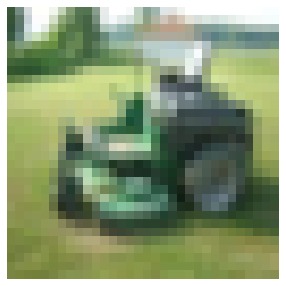

In [38]:
#generating a random number to display a random image from the dataset along with the label's number and name

rcParams['figure.figsize'] = 5,5

img = np.random.randint(0, len(X_train))

plt.imshow(X_train[img])

plt.axis('off')

print("Image Number Selected: {}".format(img))
print("Image Shape: {}".format(X_train[img].shape))
print("Image Super Category Number: {}".format(train['coarse_labels'][img]))
print("Image SuperCategory Name: {}".format(super_category.iloc[train['coarse_labels'][img]][0].capitalize()))
print("Image Sub-Category Number: {}".format(train['fine_labels'][img]))
print("Image Sub-Category Name: {}".format(sub_category.iloc[train['fine_labels'][img]][0]))

# print("Shape of image : {}".format(X_train[img].shape))
# print("Image category number: {}".format(train['coarse_labels'][img]))
# print("Image category name: {}".format(category.iloc[trainData['coarse_labels'][imageId]][0].capitalize()))
# print("Image subcategory number: {}".format(trainData['fine_labels'][imageId]))
# print("Image subcategory name: {}".format(subCategory.iloc[trainData['fine_labels'][imageId]][0].capitalize()))

### Exploring Few images together

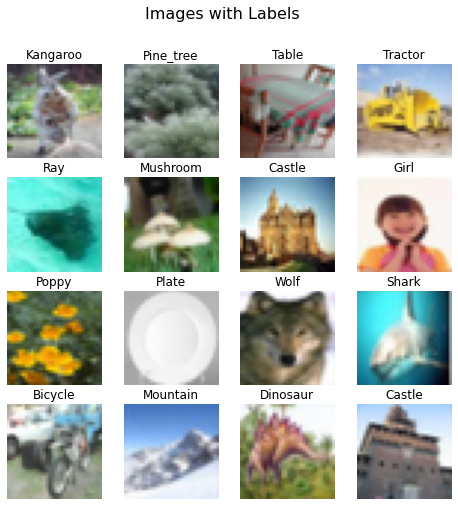

In [39]:
rcParams['figure.figsize'] = 8,8

nrow = 4
ncol = 4

img = np.random.randint(0, len(X_train), nrow*ncol)
#img

fig, axes = plt.subplots(nrow, ncol)
plt.suptitle("Images with Labels", fontsize = 16)

for i in range(0, nrow):
    for j in range(0, ncol):
        k = (i*ncol) + j 
        axes[i, j].imshow(X_train[img[k]])
        axes[i, j].set_title(sub_category.iloc[train['fine_labels'][img[k]]][0].capitalize())
        axes[i, j].axis("off")
plt.show()


## Converting Class Vectors to Binary Class Metrics

In [40]:
n_classes = 100
y_train = to_categorical(y_train, n_classes)
#y_train

y_test = to_categorical(y_test, n_classes)
y_test

array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]], dtype=float32)

## Constants

In [41]:
#resizing the images as per EfficientNetB0 to size (224, 224)
height = 224
width = 224
channels = 3

n_classes = 100
input_shape = (height, width, channels)

epochs = 60
batch_size = 8

## Image Manupulation / Image Data Generator

[https://stanford.edu/~shervine/blog/keras-how-to-generate-data-on-the-fly](http://)

In [42]:
def resize_img(img, shape):
    return cv2.resize(img, (shape[1], shape[0]), interpolation=cv2.INTER_CUBIC)

In [43]:
#---- https://www.tensorflow.org/api_docs/python/tf/image/resize
# This method requires large memory

# X_train_data = []
# for i in range(49992 ,len(X_train)):
#     X_train_data.append(tf.image.resize(X_train[i], #Image
#                          [244,244], #size 
#                          method = ResizeMethod.BILINEAR, #Method
#                          preserve_aspect_ratio = False, 
#                          antialias = False, 
#                          name = None))

# X_train_data = np.asarray(X_train_data)

### Custom Data Generator class

In [44]:
class DataGenerator(keras.utils.Sequence):
    def __init__(self, images, labels = None, mode = 'fit', batch_size = batch_size, dim = (height, width), channels = channels, n_classes = n_classes, shuffle = True, augment = False):
        
        #initializing the configuration of the generator
        self.images = images
        self.labels = labels
        self.mode = mode
        self.batch_size = batch_size
        self.dim = dim
        self.channels = channels
        self.n_classes = n_classes
        self.shuffle = shuffle
        self.augment = augment
        self.on_epoch_end()
   
    #method to be called after every epoch
    def on_epoch_end(self):
        self.indexes = np.arange(self.images.shape[0])
        if self.shuffle == True:
            np.random.shuffle(self.indexes)
    
    #return numbers of steps in an epoch using samples and batch size
    def __len__(self):
        return int(np.floor(len(self.images) / self.batch_size))
    
    #this method is called with the batch number as an argument to obtain a given batch of data
    def __getitem__(self, index):
        #generate one batch of data
        #generate indexes of batch
        batch_indexes = self.indexes[index * self.batch_size:(index+1) * self.batch_size]
        
        #generate mini-batch of X
        X = np.empty((self.batch_size, *self.dim, self.channels))
        
        for i, ID in enumerate(batch_indexes):
            #generate pre-processed image
            img = self.images[ID]
            #image rescaling
            img = img.astype(np.float32)/255.
            #resizing as per new dimensions
            img = resize_img(img, self.dim)
            X[i] = img
            
        #generate mini-batch of y
        if self.mode == 'fit':
            y = self.labels[batch_indexes]
            
            #augmentation on the training dataset
            if self.augment == True:
                X = self.__augment_batch(X)
            return X, y
        
        elif self.mode == 'predict':
            return X
        
        else:
            raise AttributeError("The mode should be set to either 'fit' or 'predict'.")
            
    #augmentation for one image
    def __random_transform(self, img):
        composition = albu.Compose([albu.HorizontalFlip(p = 0.5),
                                   albu.VerticalFlip(p = 0.5),
                                   albu.GridDistortion(p = 0.2),
                                   albu.ElasticTransform(p = 0.2)])
        return composition(image = img)['image']
    
    #augmentation for batch of images
    def __augment_batch(self, img_batch):
        for i in range(img_batch.shape[0]):
            img_batch[i] = self.__random_transform(img_batch[i])
        return img_batch

In [45]:
train_data_generator = DataGenerator(X_train, y_train, augment = True)
valid_data_generator = DataGenerator(X_test, y_test, augment = False)

In [46]:
# datagen = ImageDataGenerator(rotation_range=10, # rotate the image 20 degrees
#                              width_shift_range=0.20, # Shift the pic width by a max of 5%
#                              height_shift_range=0.20, # Shift the pic height by a max of 5%
#                              rescale=1/255, # Rescale the image by normalzing it.
#                              shear_range=0.1, # Shear means cutting away part of the image (max 10%)
#                              zoom_range=0.1, # Zoom in by 10% max
#                              horizontal_flip=True, # Allo horizontal flipping
#                              fill_mode='nearest', # Fill in missing pixels with the nearest filled value
#                              featurewise_center=True,
#                              featurewise_std_normalization=True,
#                             )

# Model
------------------------------------
### Using pre-trained EfficientNetB0

##### [https://keras.io/api/applications/efficientnet/](http://)
##### [https://keras.io/examples/vision/image_classification_efficientnet_fine_tuning/](http://)

In [47]:
efnb0 = efn.EfficientNetB0(weights = 'imagenet', include_top = False, input_shape = input_shape, classes = n_classes)

model = Sequential()
model.add(efnb0)
model.add(GlobalAveragePooling2D())
model.add(Dropout(0.5))
model.add(Dense(n_classes, activation = 'softmax'))

model.summary()

16809984/16804768 [==============================] - 1s 0us/step
Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
efficientnet-b0 (Functional) (None, 7, 7, 1280)        4049564   
_________________________________________________________________
global_average_pooling2d (Gl (None, 1280)              0         
_________________________________________________________________
dropout (Dropout)            (None, 1280)              0         
_________________________________________________________________
dense (Dense)                (None, 100)               128100    
Total params: 4,177,664
Trainable params: 4,135,648
Non-trainable params: 42,016
_________________________________________________________________


In [48]:
optimizer = Adam(lr = 0.0001)

#early stopping to monitor the validation loss and avoid overfitting
early_stop = EarlyStopping(monitor ='val_loss', mode = 'min', verbose = 1, patience = 10, restore_best_weights = True)

#reducing learning rate on plateau
rlrop = ReduceLROnPlateau(monitor ='val_loss', mode = 'min', patience = 5, factor = 0.5, min_lr = 1e-6, verbose = 1)

In [49]:
#model compiling
model.compile(optimizer = optimizer, loss = 'categorical_crossentropy', metrics = ['accuracy'])

In [50]:
model_history = model.fit(train_data_generator,
                            validation_data = valid_data_generator,
                            callbacks = [early_stop, rlrop],
                            verbose = 1,
                            epochs = epochs)

Epoch 1/60
6250/6250 [==============================] - 845s 133ms/step - loss: 3.2595 - accuracy: 0.2408 - val_loss: 1.0145 - val_accuracy: 0.6979
Epoch 2/60
6250/6250 [==============================] - 829s 133ms/step - loss: 1.5866 - accuracy: 0.5613 - val_loss: 0.8612 - val_accuracy: 0.7517
Epoch 3/60
6250/6250 [==============================] - 830s 133ms/step - loss: 1.2925 - accuracy: 0.6399 - val_loss: 0.8449 - val_accuracy: 0.7718
Epoch 4/60
6250/6250 [==============================] - 834s 133ms/step - loss: 1.1168 - accuracy: 0.6801 - val_loss: 0.7974 - val_accuracy: 0.7818
Epoch 5/60
6250/6250 [==============================] - 832s 133ms/step - loss: 1.0023 - accuracy: 0.7131 - val_loss: 0.7778 - val_accuracy: 0.7970
Epoch 6/60
6250/6250 [==============================] - 849s 136ms/step - loss: 0.9183 - accuracy: 0.7343 - val_loss: 0.7623 - val_accuracy: 0.8005
Epoch 7/60
6250/6250 [==============================] - 832s 133ms/step - loss: 0.8233 - accuracy: 0.7595 - val_

In [51]:
#saving the trained model as data file in .h5 format
#model.save(path + 'Model\\' + 'CIFAR-100_model.h5')

#Save Model on Kaggle
#model.save('CIFAR-100_model.h5')

In [52]:
#saving the trained model weights as data file in .h5 format
#model.save_weights(path + 'Model\\' + 'cifar-100_Weights.h5')

# Save Weights on Kaggle
#model.save_weights("CIFAR-100_model_weights.h5")

## Load Model

In [53]:
# #Load Model Locally
# model = load_model(path + 'Model\\' + 'CIFAR-100_model.h5')

# #Load Model on Kaggle
# #model = load_model('CIFAR-100_model.h5')

## Model Plots (History)

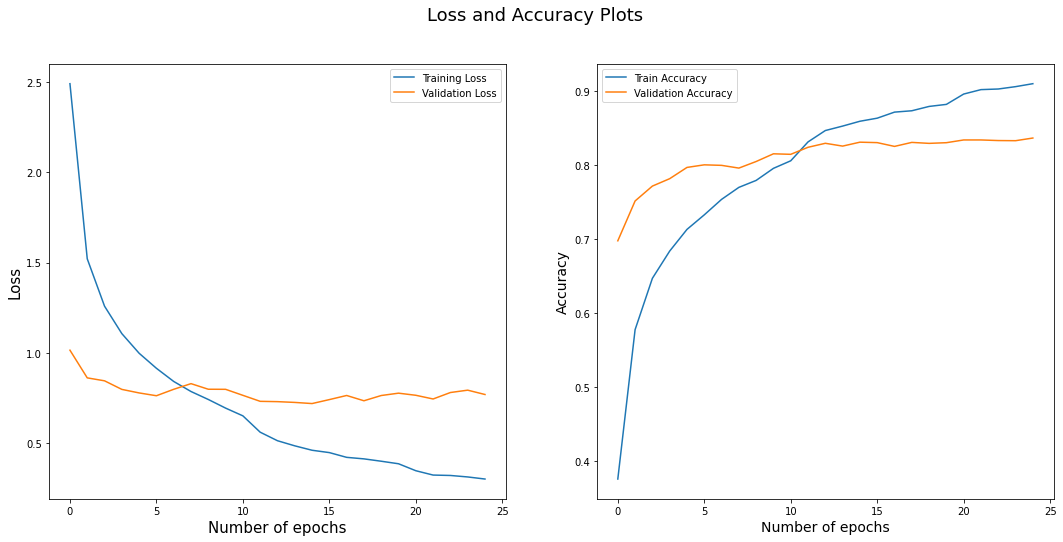

In [54]:
#plot to visualize the loss and accuracy against number of epochs
plt.figure(figsize=(18,8))

plt.suptitle('Loss and Accuracy Plots', fontsize = 18)

plt.subplot(1,2,1)
plt.plot(model_history.history['loss'], label = 'Training Loss')
plt.plot(model_history.history['val_loss'], label = 'Validation Loss')
plt.legend()
plt.xlabel('Number of epochs', fontsize = 15)
plt.ylabel('Loss', fontsize = 15)

plt.subplot(1,2,2)
plt.plot(model_history.history['accuracy'], label = 'Train Accuracy')
plt.plot(model_history.history['val_accuracy'], label ='Validation Accuracy')
plt.legend()
plt.xlabel('Number of epochs', fontsize = 14)
plt.ylabel('Accuracy', fontsize = 14)
plt.show()

## Model Evaluation

In [55]:
valid_loss, valid_accuracy = model.evaluate_generator(generator = valid_data_generator, verbose = 1)

print('\n')
print("Test or Validation Loss: ", round(valid_loss * 100, 2), '%')
print('Validation Accuracy: ', round((valid_accuracy * 100), 2), "%")


   4/1250 [..............................] - ETA: 27s - loss: 0.4333 - accuracy: 0.8750 

/opt/conda/lib/python3.7/site-packages/tensorflow/python/keras/engine/training.py:1877: UserWarning: `Model.evaluate_generator` is deprecated and will be removed in a future version. Please use `Model.evaluate`, which supports generators.
  warnings.warn('`Model.evaluate_generator` is deprecated and '


1250/1250 [==============================] - 19s 15ms/step - loss: 0.7190 - accuracy: 0.8311


Test or Validation Loss:  71.9 %
Validation Accuracy:  83.11 %


In [56]:
#Since model.evaluate_generator() is being deprecated

In [57]:
valid_loss, valid_accuracy = model.evaluate(valid_data_generator, verbose = 1)

print('\n')
print("Test or Validation Loss: ", round(valid_loss * 100, 2), '%')
print('Validation Accuracy: ', round((valid_accuracy * 100), 2), "%")

1250/1250 [==============================] - 18s 14ms/step - loss: 0.7190 - accuracy: 0.8311


Test or Validation Loss:  71.9 %
Validation Accuracy:  83.11 %


## Model Prediction

In [58]:
y_pred = model.predict_generator(DataGenerator(X_test, mode = 'predict', augment = False, shuffle = False), verbose = 1)
y_pred = np.argmax(y_pred, axis = 1)

test_accuracy = accuracy_score(np.argmax(y_test, axis = 1), y_pred) #sklearn.metrics.accuracy_score(y_true, y_pred, *, normalize=True, sample_weight=None)
print('Test Accuracy: ', round((test_accuracy * 100), 2), "%")

/opt/conda/lib/python3.7/site-packages/tensorflow/python/keras/engine/training.py:1905: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  warnings.warn('`Model.predict_generator` is deprecated and '


1250/1250 [==============================] - 18s 13ms/step
Test Accuracy:  83.11 %


In [59]:
#Since model.predict_genrator() is being deprecated

In [60]:
y_pred = model.predict(DataGenerator(X_test, mode = 'predict', augment = False, shuffle = False), verbose = 1)
y_pred = np.argmax(y_pred, axis = 1)

test_accuracy = accuracy_score(np.argmax(y_test, axis = 1), y_pred) #tsklearn.metrics.accuracy_score(y_true, y_pred, *, normalize=True, sample_weight=None)
print('Test Accuracy: ', round((test_accuracy * 100), 2), "%")

1250/1250 [==============================] - 17s 13ms/step
Test Accuracy:  83.11 %


## Confusion Matrix

In [61]:
cm = confusion_matrix(np.argmax(y_test, axis = 1), y_pred)
print(cm)

[[98  0  0 ...  0  0  0]
 [ 0 94  0 ...  0  0  0]
 [ 0  0 77 ...  0  2  0]
 ...
 [ 0  0  0 ... 87  0  0]
 [ 0  0  3 ...  0 72  0]
 [ 0  0  0 ...  0  0 86]]


In [62]:
#report to see which category has been predicted incorectly and which has been predicted correctly
target = ["Category {}".format(i) for i in range(n_classes)]
print(classification_report(np.argmax(y_test, axis = 1), y_pred, target_names = target))

              precision    recall  f1-score   support

  Category 0       0.86      0.98      0.92       100
  Category 1       0.94      0.94      0.94       100
  Category 2       0.71      0.77      0.74       100
  Category 3       0.82      0.81      0.81       100
  Category 4       0.76      0.76      0.76       100
  Category 5       0.84      0.78      0.81       100
  Category 6       0.89      0.92      0.91       100
  Category 7       0.83      0.90      0.86       100
  Category 8       0.94      0.97      0.96       100
  Category 9       0.93      0.90      0.91       100
 Category 10       0.72      0.53      0.61       100
 Category 11       0.58      0.52      0.55       100
 Category 12       0.86      0.85      0.85       100
 Category 13       0.91      0.70      0.79       100
 Category 14       0.96      0.90      0.93       100
 Category 15       0.88      0.87      0.87       100
 Category 16       0.86      0.90      0.88       100
 Category 17       0.95    

## Visualizing the Predictions


In [63]:
#dataframe of predictions
prediction = pd.DataFrame(y_pred)
prediction.head()

,0
0,68
1,33
2,55
3,51
4,71


True Label: Aquarium_fish
Predicted Label: Aquarium_fish


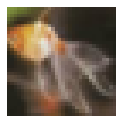

In [64]:
#generating a random number to display a random image from the dataset along with the true and predicted label
imageId = np.random.randint(0, len(X_test))

rcParams['figure.figsize'] = 2,2

plt.imshow(X_test[imageId])

plt.axis('off')

print("True Label: " + str(sub_category.iloc[test['fine_labels'][imageId]][0].capitalize()))
print("Predicted Label: " + str(sub_category.iloc[prediction.iloc[imageId]]).split()[2].capitalize())

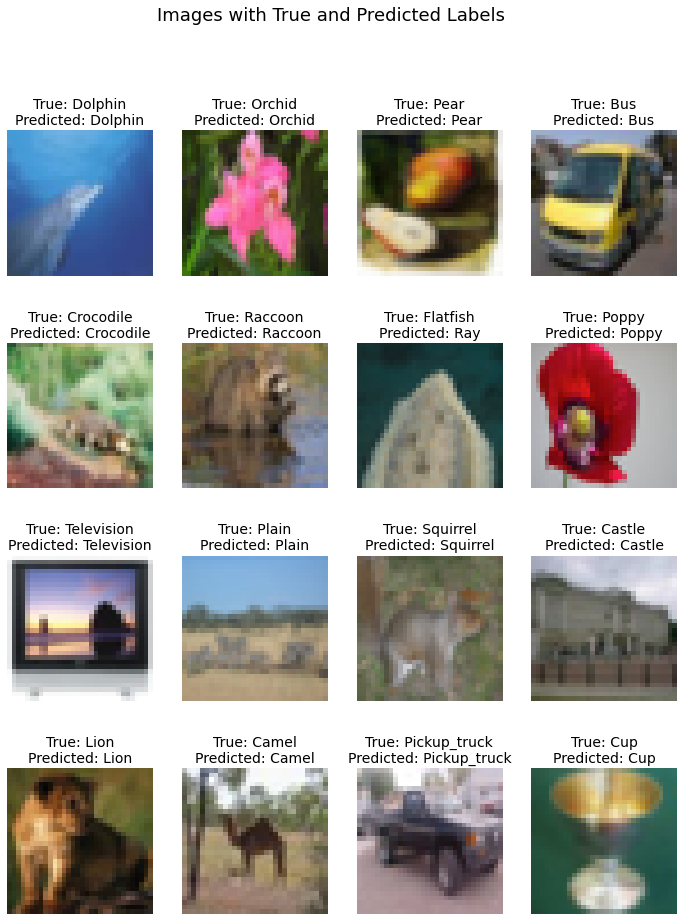

In [65]:
#16 random images to display at a time along with their true and random labels
rcParams['figure.figsize'] = 12,15

num_row = 4
num_col = 4

imageId = np.random.randint(0, len(X_test), num_row * num_col)

fig, axes = plt.subplots(num_row, num_col)

for i in range(0, num_row):
    for j in range(0, num_col):
        k = (i*num_col) + j
        axes[i,j].imshow(X_test[imageId[k]])
        axes[i,j].set_title("True: " + str(sub_category.iloc[test['fine_labels'][imageId[k]]][0]).capitalize() 
                             + "\nPredicted: " + str(sub_category.iloc[prediction.iloc[imageId[k]]]).split()[2].capitalize(), 
                            fontsize=14)
        axes[i,j].axis('off')
        fig.suptitle("Images with True and Predicted Labels", fontsize = 18) 

plt.show()

## Testing the Model

In [66]:
#function to resize the image
def resize_test_image(test_img):

    img = cv2.imread(test_img)
    #plt.imshow(img)
    img_RGB = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    #plt.imshow(img_RGB)
    resized_img = cv2.resize(img_RGB, (224, 224))
    #plt.imshow(resized_img)
    resized_img = resized_img / 255.
    #plt.imshow(resized_img)
    return resized_img
    
#resize_test_image('orange.jpeg')

In [67]:
#function to get prediction for test image from the model
def predict_test_image(test_img):
    
    resized_img = resize_test_image(test_img)
    prediction = model.predict(np.array([resized_img]))
    
    return prediction

#predict_test_image('orange.jpeg')

In [68]:
#function to get the sorted prediction
def sort_prediction_test_image(test_img):
    
    prediction = predict_test_image(test_img)
    
    index = np.arange(0,100)
    
    for i in range(100):
        for j in range(100):
            if prediction[0][index[i]] > prediction[0][index[j]]:
                temp = index[i]
                index[i] = index[j]
                index[j] = temp
                
    return index

#sort_prediction_test_image('orange.jpeg')

In [69]:
#function to get the dataframe for top 5 predictions
def df_top5_prediction_test_image(test_img):
    
    sorted_index = sort_prediction_test_image(test_img)
    prediction = predict_test_image(test_img)
    
    subCategory_name = []
    prediction_score = []
    
    k = sorted_index[:6] 
    
    for i in range(len(k)):
        subCategory_name.append(sub_category.iloc[k[i]][0])
        prediction_score.append(round(prediction[0][k[i]], 2))
        
    df = pd.DataFrame(list(zip(subCategory_name, prediction_score)), columns = ['Label', 'Probability'])  
    
    return df

#df_top5_prediction_test_image('orange.jpeg')

In [70]:
#function to get the plot for top 5 predictions 
def plot_top5_prediction_test_image(test_img):
    
    try:
    
        fig, axes = plt.subplots(1, 2, figsize = (15,4))
        fig.suptitle("Prediction", fontsize = 18)

        new_img = plt.imread(test_img)
        axes[0].imshow(new_img)
        axes[0].axis('off')

        data = df_top5_prediction_test_image(test_img)
        x = df_top5_prediction_test_image(test_img)['Label']
        y = df_top5_prediction_test_image(test_img)['Probability']

        axes[1] = sns.barplot(x = x, y = y, data = data, color ="green")

        plt.xlabel('Label', fontsize=14)
        plt.ylabel('Probability', fontsize=14)

        plt.ylim(0,1.0)

        axes[1].grid(False)
        axes[1].spines["top"].set_visible(False)
        axes[1].spines["right"].set_visible(False)
        axes[1].spines["bottom"].set_visible(False)
        axes[1].spines["left"].set_visible(False)

        plt.show()
    
    except Exception as e:
        print("Check file path or file name")

In [71]:
#Local
#img_path = ''

#kaggle
img_path = '../input/images/Images/'

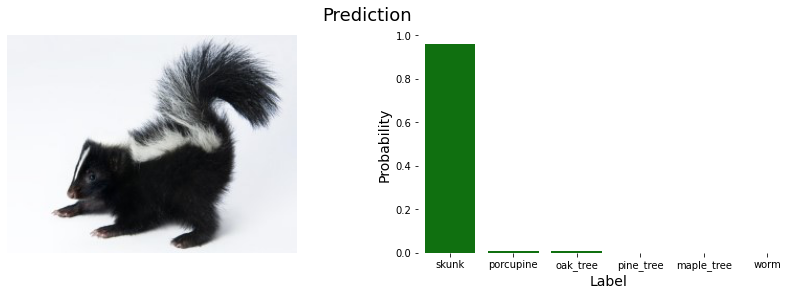

In [72]:
plot_top5_prediction_test_image(img_path + 'Skunk.jpeg')

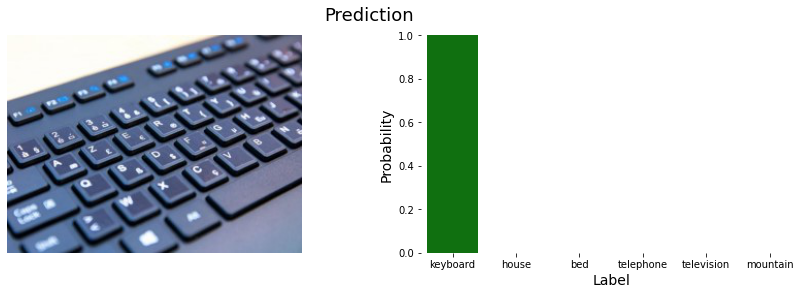

In [73]:
plot_top5_prediction_test_image(img_path + 'Keyboard.jpeg')

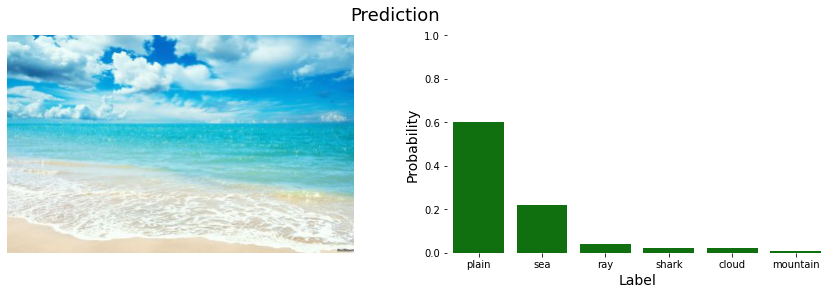

In [74]:
plot_top5_prediction_test_image(img_path + 'Sea.jpeg')

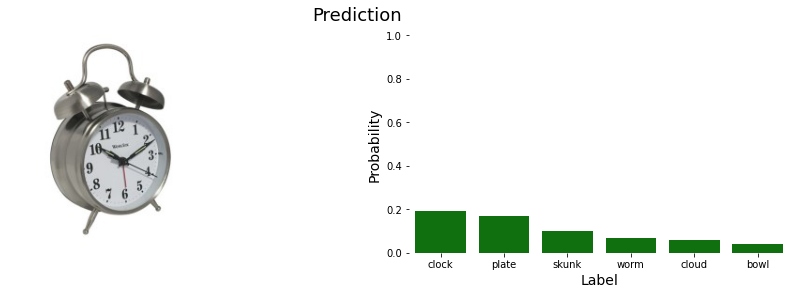

In [75]:
plot_top5_prediction_test_image(img_path + 'Clock.jpeg')

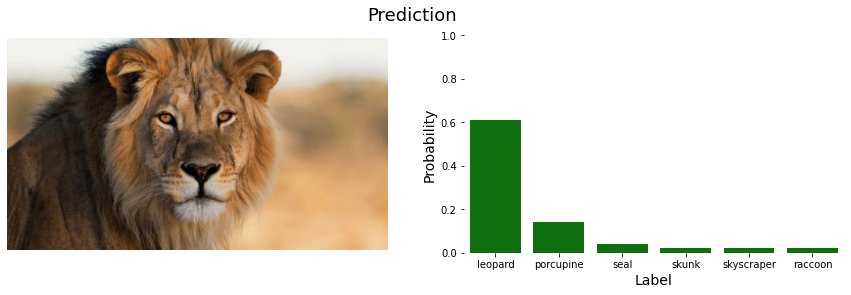

In [76]:
plot_top5_prediction_test_image(img_path + 'Lion.jpeg')

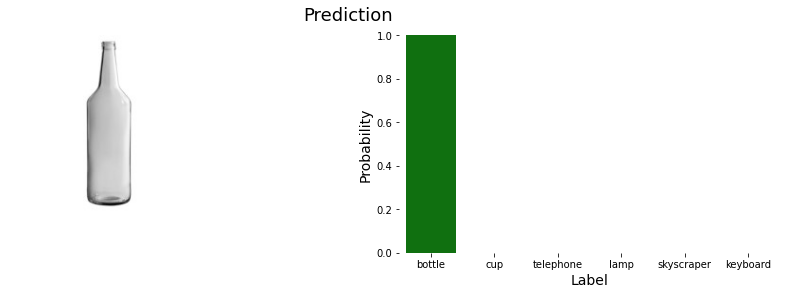

In [77]:
plot_top5_prediction_test_image(img_path + 'Bottle.jpeg')

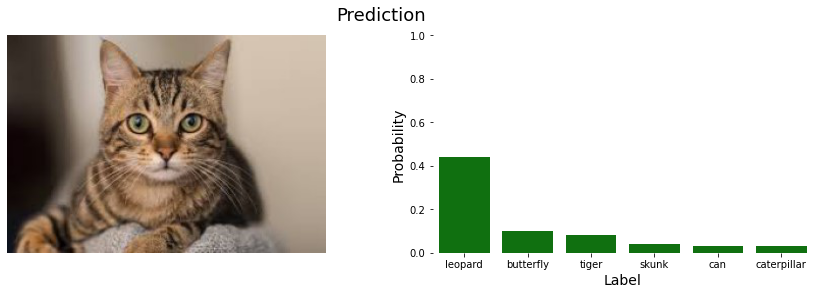

In [78]:
plot_top5_prediction_test_image(img_path + 'Cat.jpeg')

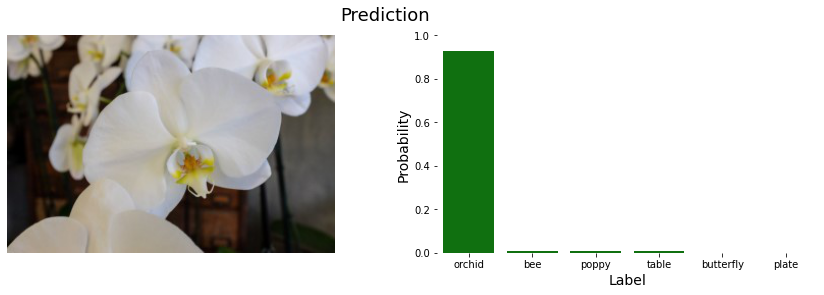

In [79]:
plot_top5_prediction_test_image(img_path + 'Orchid.jpeg')

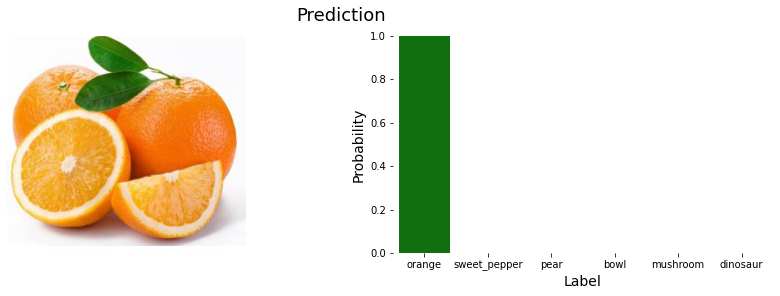

In [80]:
plot_top5_prediction_test_image(img_path + 'Orange.jpeg')

## Saving Model

In [81]:
#saving the trained model as data file in .h5 format
#model.save(path + 'Model\\' + 'CIFAR100_EfficientNetB0_Model.h5')

#save model on kaggle
model.save('CIFAR100_EfficientNetB0_Model.h5')

In [82]:
#saving model Weights
#model.save_weights(path + 'Model\\' + 'CIFAR100_EfficientNetB0_Model_Weights.h5')

#save model Weights on kaggle
model.save("CIFAR100_EfficientNetB0_Model_Weights.h5")